# Random Kitchen Sinks - ideal case

## Introduction

##### Motivation for RKS

Kernel methods rely on matrix manipulation (for eg. linear system resolution) on high-dimension spaces. However, a naive implementation scales as $N^3$, which is a poor scaling. In particular, it limits the dataset that we can manipulate. The idea is to create a low rank approximation of shift invariant kernels (like the Gaussian kernel) by sampling a random subset of their kernel's Fourier components. In other terms, the <a href="https://arxiv.org/abs/2101.11020">Representative Kernel Hilbert Space</a> is approximated by a low-dimension space.

##### Explanation of the method

In order to be successful, we must get sure that the inner product in the low-dimension space is approximately equal to the inner product in the feature space (i.e. the kernel):

\begin{equation*}
    k(\textbf{x}, \textbf{x'}) \approx z(\textbf{x}). z(\textbf{x'})
\end{equation*}

In order to find the randomized feature map $z$, we apply the <a href="https://papers.nips.cc/paper/2007/hash/013a006f03dbc5392effeb8f18fda755-Abstract.html">Bochner's theorem</a> which states that a well-scaled continous positive definite shift-invariant kernel is the Fourier transform of a probability density:

\begin{equation*}
    k(\textbf{x} - \textbf{y}) = \int_{R^d} p(\omega) e^{i \omega . (\textbf{x} - \textbf{y})} d\omega
\end{equation*}

Since the kernel and the probability density are real-valued, we can replace $e^{i \omega . (\textbf{x} - \textbf{y})}$ by $\cos(\omega . (\textbf{x} - \textbf{y}))$; i.e. $ k(\textbf{x} - \textbf{y}) = E_\omega(\cos(\omega . (\textbf{x} - \textbf{y})))$. $\cos(\omega . (\textbf{x} - \textbf{y}))$ is therefore the unbiaised estimate of $k$. We can factor the expression by setting:

\begin{equation*}
z_\omega(\textbf{x}) = \sqrt{2} \cos(\omega . \textbf{x} + b)
\end{equation*}

Our goal here is to approximate the kernel by a realization of the variate. The variance of the "kernel variate" can be decreased by concatenating R independent randomly chosen $z_\omega(\textbf{x})$ and divide the obtained vector by $\sqrt{R}$. It is easy to see that the variance of the inner product is divided by $R$.

The concept can be represented by the following picture:

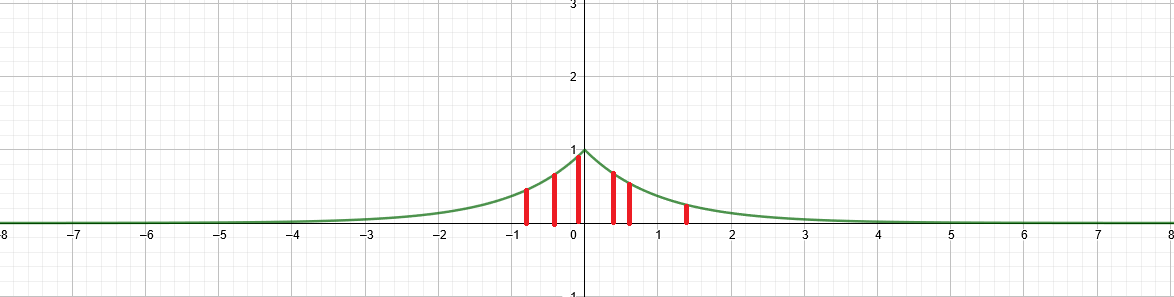

Here, we see that from the Fourier transform of some function, we extracted some frequencies from the the spectrum by the law of the Fourier transform. From this simple observation, we understood that we could use *unknown* kernels only by extracting the frequencies according to some probability distribution. This notebook proposes an implementation of this idea by using the *continuous* probability distributions from the module **numpy.random**.

One other way to understand this method is, since the Fourier transform is (up to a factor) an involution, to see it as a Fourier tranform computation of any finite measure on $\mathbb{R}$.

##### Convergence

Since the product of $2$ terms is bound (because $\cos$ is a bound function), <a href="https://papers.nips.cc/paper/2007/hash/013a006f03dbc5392effeb8f18fda755-Abstract.html">it can be shown</a> by using Hoeffding's inequality that the inner product $z(\textbf{x}).z(\textbf{y})$ converges locally uniformly to $k(\textbf{x}, \textbf{y})$.

##### Model definition

Recalling the kernel development of the model:

\begin{equation*}
    f(x) = \sum_{i = 1}^N \ \beta_i \ k(x, x_i) = \left(\sum_{i = 1}^N \ \beta_i \ z(x_i)\right).z(x),
\end{equation*}

one can see that the model is linear in the random Fourier feature $z(x)$. <a href="https://arxiv.org/abs/2107.05224v1">Gan et al </a>. gives the linear system whose solution is the vector representative $c_{opt}$ of the linear model:

\begin{equation*}
    (z(X)^T z(X) + \alpha \ I_R) \ c_{opt} \ = \ z(X)^T \ y
\end{equation*}

where $\alpha$ is the regularization parameter and $y$ the classification vector and :

\begin{equation*}
    z(X) = \left(z(x_1) ... \ z(x_N) \right)^T
\end{equation*}

The kernel that we get is according to <a href="https://arxiv.org/abs/2107.05224v1">Gan et al </a>:

\begin{equation*}
    k(\textbf{x}, \textbf{y}) = e^{- \frac{k^2 \gamma^2}{2} (\textbf{x}-\textbf{y})^2}
\end{equation*}

##### Quantum implementation
Here again, the goal is to compute *via* a quantum circuit the function $x \mapsto \sqrt{2} \cos{k x}$, where $k$ is a parameter. For the sake of simplicity, we take $k = 1$ and we fine-tune $\gamma$ according to our needs. Here, it seems that $\gamma = 0.1$ works fine.

We use the following circuit:

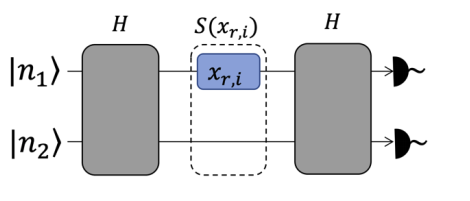

where $x_{r, i} = \gamma (\omega_r . x_i + b_r)$ and the $H$ components are $50-50$-beam spliters.

The input state is the state $|n, 0>$, where $n$ is the number of photons, here $n = 1$.

## Use of a theoritical $\lambda$ for computing $x \mapsto \sqrt{2} \cos x$

It can be shown that the unitary matrix of our circuit is:

\begin{equation*}
\begin{pmatrix}
\frac{e^{ix} - 1}{2} & \frac{i(e^{ix} + 1)}{2} \\
\frac{i(e^{ix} + 1)}{2} & -\frac{e^{ix} - 1}{2} 
\end{pmatrix}
\end{equation*}

If we send a single photon, we get the following probabilites:

\begin{equation*}
|<1-m, m|\mathcal{U}(x)|1, 0>|^2 = \cos^{2m}\left(\frac{x}{2}\right) \sin^{2(n-m)}\left(\frac{x}{2}\right)
\end{equation*}

Hence:

\begin{equation*}
\sqrt{2} \cos x = \sqrt{2} \left(|<0, 1|\mathcal{U}(x)|1, 0>|^2 - |<1, 0|\mathcal{U}(x)|1, 0>|^2 \right)
\end{equation*}

In the remaining of our notebook, we use this theoritical value of $\lambda$.

### Importation of modules

In [1]:
import numpy as np
import perceval as pcvl
import perceval.lib.phys as phys
from math import comb
import sklearn.datasets as skdt
import time
from scipy.optimize import basinhopping
from copy import deepcopy
import matplotlib.pyplot as plt
import pybobyqa
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.utils import algorithm_globals
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

### Definition of the constants, the circuit and the simulator

In [2]:
m = 2 # number of modes
n = 1 # number of photons
input_state = pcvl.BasicState([n, 0]) # |n, 0>
x_ri = pcvl.P("x_ri") # parameter x_r,i = gamma * (w_r . x_i + b_r)
k = 1

In [3]:
simulator_backend = pcvl.BackendFactory().get_backend("SLOS") # definition of the backend
s1 = simulator_backend(pcvl.Matrix.random_unitary(m)) # some matrix that will be changed later
s1.compile(input_state) 
c = phys.BS() // (0, phys.PS(x_ri)) // phys.BS() # cicruit definition
pcvl.pdisplay(c) # graphical representation

In [4]:
def quantum_value(xRI, lambda_random):
    """
    Wrapper that define the quantum circuit computation
    """
    x_ri.set_value(xRI % (2 * np.pi)) # set the new phase of the phase shifter
    U = c.compute_unitary(use_symbolic=False) # define the new circuit matrix
    s1.U = U # modify the unitary matrix of the simulator
    return np.sum(np.multiply(s1.all_prob(input_state), lambda_random)) # observable computation

### Definition of  constants

The value of $R$ is very important. It defines the expressivity of the circuit. On the one hand, a too small value leads to the under-fitting. On th other hand, a too large value leads to over-fitting. Moreover, the approximation of replacing the expectancy by the realization require a value high enough. For this reason, *the wrapper at the end of the notebook redefines its value according to the following (empircally found) rules*:

1. For linear datasets: $R = 3$
2. For circular datasets: $R = 10$
3. For lunar datasets: $R = 20$

In [5]:
h = .03    # step size in the mesh
gamma = 0.1 # scale parameter
R = 20   # this is the key value

#### Value of $\lambda$

The value of $\lambda$ was found through the minimization of the loss function.

The loss is: $2.2786055010585336 \times 10^{-5}$.

In [6]:
lambda_random =np.array([np.sqrt(2), -np.sqrt(2)])

##### Comparaison of the real and the quantum kernel

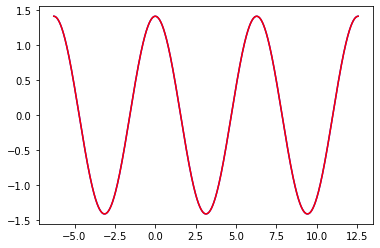

In [7]:
X = np.linspace(-2 * np.pi, 4 * np.pi, num = 1000)
plt.plot(X, [quantum_value(x, lambda_random) for x in X], 'b')
plt.plot(X, np.sqrt(2) * np.cos(X), 'r')
plt.show()

### Data generation

The input points are normalized in order to make the graphical representation easier. Moreover, as it will become clear later, this normalization makes the kernels we generate useful.

In [8]:
def normalizeX(z):
    """
    Sets the values between -1 and 1 linearly
    """
    zmax = np.max(z)
    zmin = np.min(z)
    return 2 * (z - zmin) / (zmax - zmin) - 1

def normalizey(z):
    """
    Values between -1 and 1 by replacing 0 values by -1
    """
    for i in range(len(z)):
        if z[i] == 0:
            z[i] = -1
    return z

def generate_data(type, N, noise_param):
    """
    Generates random datasets of different types
    type == 0: linear dataset
    type == 1: circular dataset
    type == 2: lunar dataset
    
    >> Default noise values:
        - linear dataset: 2
        - circular dataset: 0.03
        - lunar dataset: 0.1
    """
    if type == 0 and noise_param is None: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = 2)
    elif type == 0: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = noise_param)
    elif type == 1 and noise_param is None: # circlar
        X, y = skdt.make_circles(n_samples=N, noise=0.03)
    elif type == 1: # circlar
        X, y = skdt.make_circles(n_samples=N, noise= noise_param)
    elif type == 2 and noise_param is None:
        X, y = skdt.make_moons(n_samples=N, noise=0.1)
    elif type == 2:
        X, y = skdt.make_moons(n_samples=N, noise=noise_param)
    else: # verify that the input type is not erroneous
        raise(ValueError("Invalid value of type. Enter help(generate_data) for more information"))

    # data normalization
    X = normalizeX(X)
    y = normalizey(y)
    return X, y

### Definition of the random Fourier features

Here we define the random Fourier features. We propose several Fourier transform distributions from **numpy.random**.

In [9]:
def random_parameter(name_law, d = 2):
    """
    sets a new value to the x_{r,i} parameter
    
    Symmetry of the Fourier transform is not required since the real part is already taken 
    (we use cosines instead of complex exponentials).
    
    >> Available names:
    
        - exponential: np.random.exponential(size = d)
        - chisquare: np.random.chisquare(1, size = d)
        - beta: np.random.beta(2, 2, size = d)
        - lognormal: np.random.lognormal(size = d)
        - logistic: np.random.logistic(size = d)
        - laplace: np.random.laplace(size = d)
        - gamma: np.random.gamma(2, size = d)
        - triangular: np.random.triangular(-1, 1, size = d)
        - cauchy: np.random.standard_cauchy(size = d)
        - pareto: np.random.pareto(1, size = d)
        - normal: np.random.normal(size = d)
        - vonmises: np.random.vonmises(0, 4, size = d)
        - uniform: np.random.uniform(low=-1, high=1, size = d)
        - wald: np.random.wald(3, 2, size = d)
        - weibull: np.random.weibull(5, size = d)
        - student: np.random.standard_t(1, size = d)
        - f (Fisher-Snedecor): np.random.f(100, 100, size = d)
    """
    
    # omega definition
    if name_law == "exponential":
        w_r = np.random.exponential(size = d) 
    elif name_law == "chisquare":
        w_r = np.random.chisquare(1, size = d)
    elif name_law == "beta":
        w_r = np.random.beta(2, 2, size = d)
    elif name_law == "lognormal":
        w_r = np.random.lognormal(size = d)
    elif name_law == "logistic":
        w_r = np.random.logistic(size = d)
    elif name_law == "laplace":
        w_r = np.random.laplace(size = d)
    elif name_law == "gamma":
        w_r = np.random.gamma(2, size = d)
    elif name_law == "triangular":
        w_r = np.random.triangular(-1, 0,  1, size = d)
    elif name_law == "cauchy":
        w_r = np.random.standard_cauchy(size = d)
    elif name_law == "pareto":
        w_r = np.random.pareto(1, size = d)
    elif name_law == "normal":
        w_r = np.random.normal(size = d)
    elif name_law == "vonmises":
        w_r = np.random.vonmises(0, 4, size = d)
    elif name_law == "uniform":
        w_r = np.random.uniform(low=-1, high=1, size = d)
    elif name_law == "wald":
        w_r = np.random.wald(3, 2, size = d)
    elif name_law == "weibull":
        w_r = np.random.weibull(5, size = d)
    elif name_law == "student":
        w_r = np.random.standard_t(1, size = d)
    elif name_law == "f":
        w_r = np.random.f(100, 100, size = d)
    else:
        raise("Value Error: Law name undefined")
        
    b_r = np.random.uniform(0, 2 * np.pi)
    return w_r, b_r


### Definition of the linear operations on the Fourier features

Even though <a href="https://arxiv.org/abs/2107.05224v1">Gan et al </a> states that $c_ {opt}$ is computed through the formula:

\begin{equation*}
    c_{opt} \ = (z(X)^T z(X) + \alpha \ I_R)^{-1}\ z(X)^T \ y,
\end{equation*}

it is well-known that a linear system resolution is faster than a matrix inversion and matricial product. We therefore encoded this formula through the resolution of the linear system:

\begin{equation*}
    (z(X)^T z(X) + \alpha \ I_R) \ c_{opt} \ = \ z(X)^T \ y
\end{equation*}

In [10]:
def q_z(X):
    """
    Defines the vector containing the different Fourier terms with the correct normalization
    """
    res = []
    for r in range(R):
        res.append(quantum_value(gamma * (np.dot(w[r], X) + b[r]), lambda_random))  # x_r,i = gamma * (w_r . x_i + b_r)
    return np.array(res) / np.sqrt(R) # normalization

def qZ(X):
    """
    Defines the matrix z(X) from the Fourier feature vectors
    """
    res = []
    print(">>> Resolve linear system")
    for i in tqdm(range(len(X))):
        res.append(q_z(X[i])) # this way of defining the matrix computes the transposition directly
    return np.array(res) / np.sqrt(R) # normalization

def c_opt(mat_Z, y):
    """
    Defines the resolution of the linear system.
    
    Inputs: z(X) matrix and the training label vector y
    """
    mat_Z_t = np.transpose(mat_Z)
    return np.linalg.solve(mat_Z_t @ mat_Z, mat_Z_t @ y)

def q_classifier(c_opt_val, x):
    """
    Defines the classifier that is linear in the Fourier feature space.
    We still have to take the sign in order to get the actual classification.
    """
    return np.dot(c_opt_val, q_z(x)) # inner product between c_opt and z(x)

#### Definition of the kernel

Thanks to what we have defined previously, we can compute an approximate value of different kernels. These values will not be used afterwards. However, we believe that, through this demonstration, the power of the RKS method will become obvious.

In [11]:
def kernel(x, y, R_value, name_law):
    global R, w, b
    R = R_value
    w = []
    b = []
    for i in range(R):
        temp1, temp2 = random_parameter(name_law)
        w.append(temp1)
        b.append(temp2)
    return np.dot(q_z(x), q_z(y))

##### Gaussian kernel

The Gaussian kernel is generated from the normal spectrum.

100%|██████████| 1000/1000 [00:15<00:00, 64.41it/s]


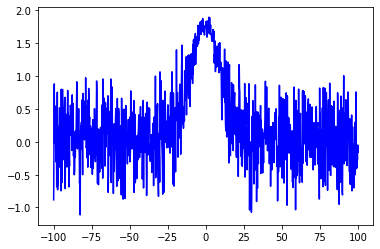

In [12]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "normal") for x in tqdm(X)], 'b')
plt.show()

100%|██████████| 1000/1000 [02:37<00:00,  6.33it/s]


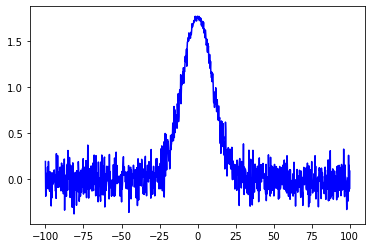

In [13]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "normal") for x in tqdm(X)], 'b')
plt.show()

##### Laplace kernel

Laplace kernel is generated from Cauchy spectrum.

100%|██████████| 1000/1000 [00:17<00:00, 56.78it/s]


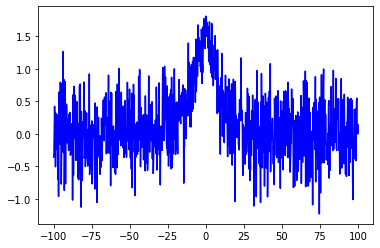

In [71]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "cauchy") for x in tqdm(X)], 'b')
plt.show()

100%|██████████| 1000/1000 [02:49<00:00,  5.90it/s]


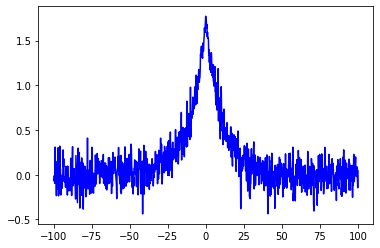

In [74]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "cauchy") for x in tqdm(X)], 'b')
plt.show()

##### Cauchy kernel

Cauchy kernel is generated from Laplace spectrum.

100%|██████████| 1000/1000 [00:17<00:00, 56.55it/s]


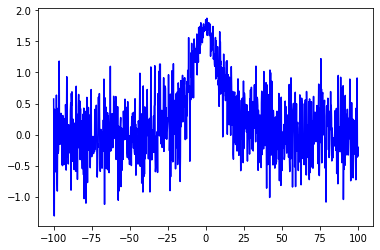

In [75]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "laplace") for x in tqdm(X)], 'b')
plt.show()

100%|██████████| 1000/1000 [02:52<00:00,  5.79it/s]


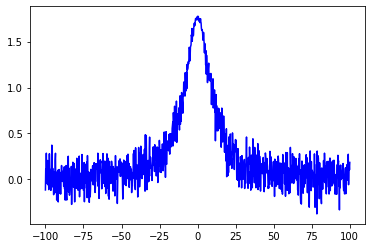

In [76]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "laplace") for x in tqdm(X)], 'b')
plt.show()

##### Sinc "kernel"

Sinc kernel is generated from a unifrom spectrum.




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 5/1000 [00:00<00:20, 47.47it/s]


  1%|          | 11/1000 [00:00<00:19, 50.04it/s]


  2%|▏         | 17/1000 [00:00<00:18, 52.59it/s]


  2%|▏         | 23/1000 [00:00<00:17, 54.88it/s]


  3%|▎         | 29/1000 [00:00<00:17, 56.33it/s]


  4%|▎         | 35/1000 [00:00<00:16, 57.13it/s]


  4%|▍         | 41/1000 [00:00<00:16, 57.75it/s]


  5%|▍         | 47/1000 [00:00<00:16, 58.31it/s]


  5%|▌         | 53/1000 [00:00<00:16, 58.60it/s]


  6%|▌         | 59/1000 [00:01<00:16, 56.39it/s]


  6%|▋         | 65/1000 [00:01<00:16, 56.65it/s]


  7%|▋         | 71/1000 [00:01<00:16, 57.38it/s]


  8%|▊         | 77/1000 [00:01<00:15, 58.09it/s]


  8%|▊         | 84/1000 [00:01<00:15, 58.92it/s]


  9%|▉         | 91/1000 [00:01<00:15, 59.40it/s]


 10%|▉         | 97/1000 [00:01<00:15, 59.48it/s]


 10%|█         | 103/1000 [00:01<00:15, 59.42it/s]


 11%|█         | 110/1000 [00:01<00:14, 59.82it/s]


 12%|█▏        | 

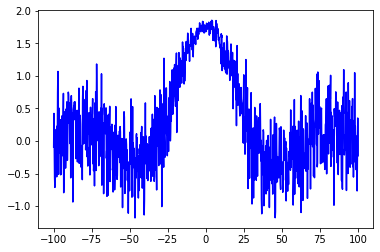

In [81]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "uniform") for x in tqdm(X)], 'b')
plt.show()





  0%|          | 0/1000 [00:00<?, ?it/s]



  0%|          | 1/1000 [00:00<02:55,  5.70it/s]



  0%|          | 2/1000 [00:00<03:16,  5.07it/s]



  0%|          | 3/1000 [00:00<03:07,  5.30it/s]



  0%|          | 4/1000 [00:00<03:04,  5.39it/s]



  0%|          | 5/1000 [00:00<03:02,  5.46it/s]



  1%|          | 6/1000 [00:01<03:04,  5.40it/s]



  1%|          | 7/1000 [00:01<03:01,  5.47it/s]



  1%|          | 8/1000 [00:01<02:59,  5.52it/s]



  1%|          | 9/1000 [00:01<02:58,  5.54it/s]



  1%|          | 10/1000 [00:01<02:56,  5.60it/s]



  1%|          | 11/1000 [00:01<02:54,  5.68it/s]



  1%|          | 12/1000 [00:02<02:52,  5.72it/s]



  1%|▏         | 13/1000 [00:02<02:54,  5.67it/s]



  1%|▏         | 14/1000 [00:02<02:53,  5.68it/s]



  2%|▏         | 15/1000 [00:02<02:53,  5.67it/s]



  2%|▏         | 16/1000 [00:02<02:53,  5.67it/s]



  2%|▏         | 17/1000 [00:03<02:52,  5.71it/s]



  2%|▏         | 18/1000 [00:03<02:52,  5.71it/s]



  2%|▏ 

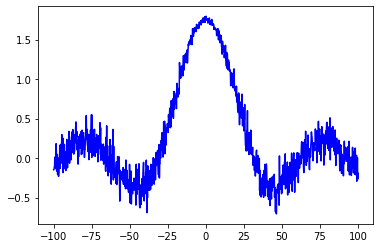

In [83]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "uniform") for x in tqdm(X)], 'b')
plt.show()

##### Squared sinc kernel

Squared sinc kernel is generated from a triangular spectrum.






  0%|          | 0/1000 [00:00<?, ?it/s]




  1%|          | 6/1000 [00:00<00:18, 54.58it/s]




  1%|          | 12/1000 [00:00<00:18, 54.67it/s]




  2%|▏         | 18/1000 [00:00<00:17, 55.51it/s]




  2%|▏         | 24/1000 [00:00<00:17, 56.18it/s]




  3%|▎         | 30/1000 [00:00<00:17, 56.67it/s]




  4%|▎         | 36/1000 [00:00<00:16, 57.44it/s]




  4%|▍         | 42/1000 [00:00<00:16, 58.03it/s]




  5%|▍         | 48/1000 [00:00<00:17, 55.44it/s]




  5%|▌         | 54/1000 [00:00<00:18, 52.36it/s]




  6%|▌         | 60/1000 [00:01<00:18, 52.21it/s]




  7%|▋         | 66/1000 [00:01<00:17, 53.04it/s]




  7%|▋         | 72/1000 [00:01<00:17, 52.85it/s]




  8%|▊         | 78/1000 [00:01<00:17, 52.49it/s]




  8%|▊         | 84/1000 [00:01<00:17, 52.66it/s]




  9%|▉         | 90/1000 [00:01<00:17, 52.35it/s]




 10%|▉         | 96/1000 [00:01<00:17, 52.08it/s]




 10%|█         | 102/1000 [00:01<00:17, 52.18it/s]




 11%|█         | 108/1000 [00:02

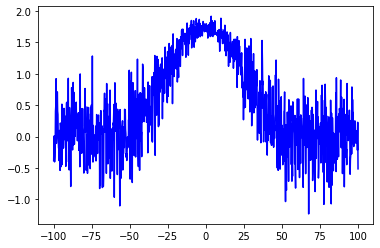

In [92]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "triangular") for x in tqdm(X)], 'b')
plt.show()






  0%|          | 0/1000 [00:00<?, ?it/s]




  0%|          | 1/1000 [00:00<03:04,  5.40it/s]




  0%|          | 2/1000 [00:00<02:56,  5.66it/s]




  0%|          | 3/1000 [00:00<02:51,  5.80it/s]




  0%|          | 4/1000 [00:00<02:49,  5.87it/s]




  0%|          | 5/1000 [00:00<02:49,  5.88it/s]




  1%|          | 6/1000 [00:01<02:48,  5.89it/s]




  1%|          | 7/1000 [00:01<02:52,  5.76it/s]




  1%|          | 8/1000 [00:01<02:51,  5.80it/s]




  1%|          | 9/1000 [00:01<02:49,  5.84it/s]




  1%|          | 10/1000 [00:01<02:48,  5.88it/s]




  1%|          | 11/1000 [00:01<02:47,  5.90it/s]




  1%|          | 12/1000 [00:02<02:46,  5.93it/s]




  1%|▏         | 13/1000 [00:02<02:45,  5.95it/s]




  1%|▏         | 14/1000 [00:02<02:45,  5.95it/s]




  2%|▏         | 15/1000 [00:02<02:46,  5.93it/s]




  2%|▏         | 16/1000 [00:02<02:46,  5.93it/s]




  2%|▏         | 17/1000 [00:02<02:45,  5.94it/s]




  2%|▏         | 18/1000 [00:03<02:47,  5

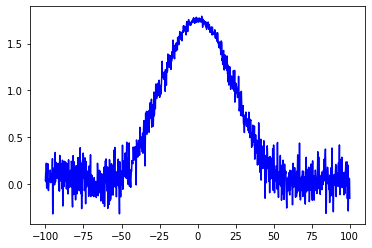

In [93]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "triangular") for x in tqdm(X)], 'b')
plt.show()

##### Other kernels

###### Fisher spectrum




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 5/1000 [00:00<00:20, 47.65it/s]


  1%|          | 11/1000 [00:00<00:19, 51.71it/s]


  2%|▏         | 17/1000 [00:00<00:17, 54.89it/s]


  2%|▏         | 23/1000 [00:00<00:17, 55.98it/s]


  3%|▎         | 29/1000 [00:00<00:17, 56.19it/s]


  4%|▎         | 35/1000 [00:00<00:17, 55.80it/s]


  4%|▍         | 41/1000 [00:00<00:16, 56.74it/s]


  5%|▍         | 47/1000 [00:00<00:16, 56.56it/s]


  5%|▌         | 53/1000 [00:00<00:17, 55.61it/s]


  6%|▌         | 59/1000 [00:01<00:16, 55.51it/s]


  6%|▋         | 65/1000 [00:01<00:16, 55.48it/s]


  7%|▋         | 71/1000 [00:01<00:16, 55.70it/s]


  8%|▊         | 77/1000 [00:01<00:16, 55.82it/s]


  8%|▊         | 83/1000 [00:01<00:16, 55.43it/s]


  9%|▉         | 89/1000 [00:01<00:16, 55.42it/s]


 10%|▉         | 95/1000 [00:01<00:16, 55.19it/s]


 10%|█         | 101/1000 [00:01<00:16, 54.98it/s]


 11%|█         | 107/1000 [00:01<00:16, 55.03it/s]


 11%|█▏        | 

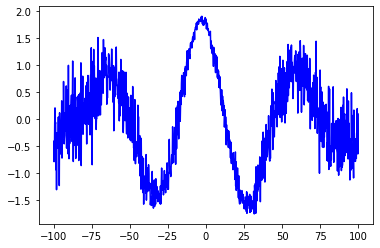

In [80]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "f") for x in tqdm(X)], 'b')
plt.show()

100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


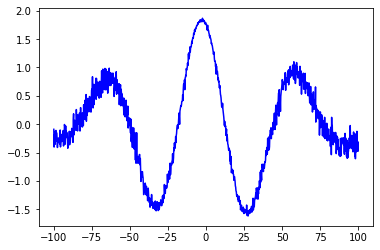

In [77]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "f") for x in tqdm(X)], 'b')
plt.show()

##### Vonmises spectrum





  0%|          | 0/1000 [00:00<?, ?it/s]



  1%|          | 6/1000 [00:00<00:18, 53.76it/s]



  1%|          | 12/1000 [00:00<00:18, 54.61it/s]



  2%|▏         | 18/1000 [00:00<00:19, 50.40it/s]



  2%|▏         | 24/1000 [00:00<00:19, 49.60it/s]



  3%|▎         | 30/1000 [00:00<00:19, 50.50it/s]



  4%|▎         | 36/1000 [00:00<00:18, 52.10it/s]



  4%|▍         | 42/1000 [00:00<00:18, 52.21it/s]



  5%|▍         | 48/1000 [00:00<00:17, 52.92it/s]



  5%|▌         | 54/1000 [00:01<00:17, 53.46it/s]



  6%|▌         | 60/1000 [00:01<00:17, 54.01it/s]



  7%|▋         | 66/1000 [00:01<00:17, 53.50it/s]



  7%|▋         | 72/1000 [00:01<00:17, 53.97it/s]



  8%|▊         | 78/1000 [00:01<00:17, 54.15it/s]



  8%|▊         | 84/1000 [00:01<00:17, 53.56it/s]



  9%|▉         | 90/1000 [00:01<00:17, 53.06it/s]



 10%|▉         | 96/1000 [00:01<00:17, 53.08it/s]



 10%|█         | 102/1000 [00:01<00:16, 53.15it/s]



 11%|█         | 108/1000 [00:02<00:16, 53.01it/s]


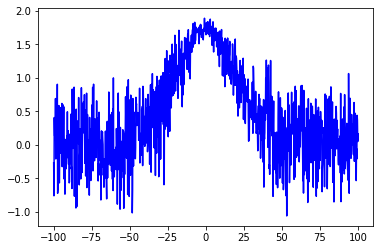

In [84]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "vonmises") for x in tqdm(X)], 'b')
plt.show()





  0%|          | 0/1000 [00:00<?, ?it/s]



  0%|          | 1/1000 [00:00<03:17,  5.06it/s]



  0%|          | 2/1000 [00:00<03:05,  5.37it/s]



  0%|          | 3/1000 [00:00<03:02,  5.45it/s]



  0%|          | 4/1000 [00:00<03:01,  5.50it/s]



  0%|          | 5/1000 [00:00<03:02,  5.44it/s]



  1%|          | 6/1000 [00:01<03:05,  5.37it/s]



  1%|          | 7/1000 [00:01<03:02,  5.45it/s]



  1%|          | 8/1000 [00:01<02:59,  5.51it/s]



  1%|          | 9/1000 [00:01<02:57,  5.59it/s]



  1%|          | 10/1000 [00:01<02:55,  5.64it/s]



  1%|          | 11/1000 [00:01<02:54,  5.66it/s]



  1%|          | 12/1000 [00:02<02:52,  5.72it/s]



  1%|▏         | 13/1000 [00:02<02:51,  5.76it/s]



  1%|▏         | 14/1000 [00:02<02:51,  5.75it/s]



  2%|▏         | 15/1000 [00:02<02:50,  5.77it/s]



  2%|▏         | 16/1000 [00:02<02:50,  5.78it/s]



  2%|▏         | 17/1000 [00:03<02:50,  5.77it/s]



  2%|▏         | 18/1000 [00:03<02:49,  5.80it/s]



  2%|▏ 

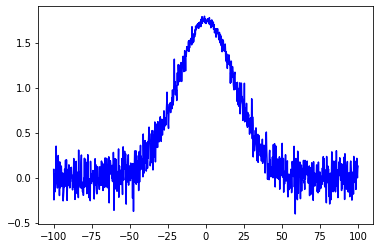

In [85]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "vonmises") for x in tqdm(X)], 'b')
plt.show()

###### Beta spectrum





  0%|          | 0/1000 [00:00<?, ?it/s]



  1%|          | 6/1000 [00:00<00:18, 52.93it/s]



  1%|          | 12/1000 [00:00<00:18, 53.10it/s]



  2%|▏         | 18/1000 [00:00<00:17, 54.81it/s]



  2%|▏         | 24/1000 [00:00<00:17, 56.19it/s]



  3%|▎         | 30/1000 [00:00<00:18, 52.87it/s]



  4%|▎         | 36/1000 [00:00<00:19, 50.62it/s]



  4%|▍         | 42/1000 [00:00<00:18, 51.82it/s]



  5%|▍         | 48/1000 [00:00<00:17, 53.88it/s]



  5%|▌         | 54/1000 [00:01<00:17, 55.24it/s]



  6%|▌         | 60/1000 [00:01<00:16, 56.05it/s]



  7%|▋         | 66/1000 [00:01<00:16, 56.91it/s]



  7%|▋         | 72/1000 [00:01<00:16, 57.23it/s]



  8%|▊         | 78/1000 [00:01<00:16, 56.85it/s]



  8%|▊         | 84/1000 [00:01<00:16, 57.00it/s]



  9%|▉         | 90/1000 [00:01<00:16, 56.14it/s]



 10%|▉         | 96/1000 [00:01<00:15, 56.50it/s]



 10%|█         | 102/1000 [00:01<00:15, 56.60it/s]



 11%|█         | 108/1000 [00:01<00:15, 57.11it/s]


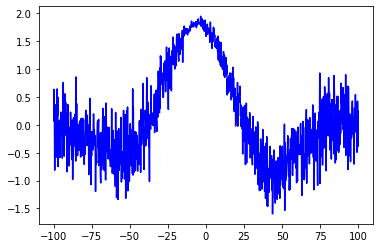

In [86]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "beta") for x in tqdm(X)], 'b')
plt.show()





  0%|          | 0/1000 [00:00<?, ?it/s]



  0%|          | 1/1000 [00:00<02:56,  5.67it/s]



  0%|          | 2/1000 [00:00<03:04,  5.40it/s]



  0%|          | 3/1000 [00:00<03:03,  5.44it/s]



  0%|          | 4/1000 [00:00<02:57,  5.62it/s]



  0%|          | 5/1000 [00:00<02:53,  5.72it/s]



  1%|          | 6/1000 [00:01<02:54,  5.69it/s]



  1%|          | 7/1000 [00:01<02:52,  5.76it/s]



  1%|          | 8/1000 [00:01<02:51,  5.77it/s]



  1%|          | 9/1000 [00:01<02:51,  5.78it/s]



  1%|          | 10/1000 [00:01<02:50,  5.81it/s]



  1%|          | 11/1000 [00:01<02:50,  5.81it/s]



  1%|          | 12/1000 [00:02<02:52,  5.74it/s]



  1%|▏         | 13/1000 [00:02<02:50,  5.80it/s]



  1%|▏         | 14/1000 [00:02<02:48,  5.84it/s]



  2%|▏         | 15/1000 [00:02<02:48,  5.85it/s]



  2%|▏         | 16/1000 [00:02<02:48,  5.85it/s]



  2%|▏         | 17/1000 [00:02<02:49,  5.78it/s]



  2%|▏         | 18/1000 [00:03<02:49,  5.79it/s]



  2%|▏ 

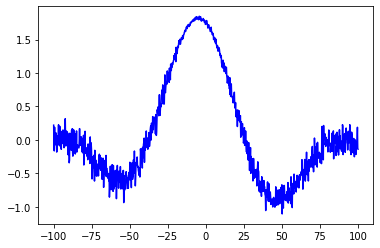

In [87]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "beta") for x in tqdm(X)], 'b')
plt.show()

###### Weibull spectrum





  0%|          | 0/1000 [00:00<?, ?it/s]



  1%|          | 6/1000 [00:00<00:18, 52.41it/s]



  1%|          | 12/1000 [00:00<00:18, 54.74it/s]



  2%|▏         | 18/1000 [00:00<00:20, 48.01it/s]



  2%|▏         | 24/1000 [00:00<00:19, 50.05it/s]



  3%|▎         | 30/1000 [00:00<00:18, 51.77it/s]



  4%|▎         | 36/1000 [00:00<00:18, 52.59it/s]



  4%|▍         | 42/1000 [00:00<00:18, 53.13it/s]



  5%|▍         | 48/1000 [00:00<00:17, 54.31it/s]



  5%|▌         | 54/1000 [00:01<00:17, 54.81it/s]



  6%|▌         | 60/1000 [00:01<00:17, 55.10it/s]



  7%|▋         | 66/1000 [00:01<00:16, 55.45it/s]



  7%|▋         | 72/1000 [00:01<00:16, 56.21it/s]



  8%|▊         | 78/1000 [00:01<00:16, 54.54it/s]



  8%|▊         | 84/1000 [00:01<00:17, 53.48it/s]



  9%|▉         | 90/1000 [00:01<00:16, 54.66it/s]



 10%|▉         | 96/1000 [00:01<00:16, 55.66it/s]



 10%|█         | 102/1000 [00:01<00:15, 56.62it/s]



 11%|█         | 108/1000 [00:01<00:15, 57.07it/s]


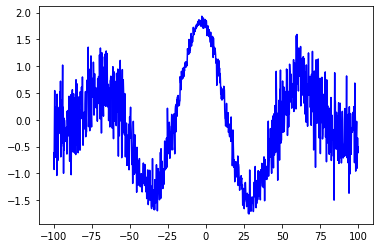

In [88]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "weibull") for x in tqdm(X)], 'b')
plt.show()





  0%|          | 0/1000 [00:00<?, ?it/s]



  0%|          | 1/1000 [00:00<03:39,  4.55it/s]



  0%|          | 2/1000 [00:00<03:36,  4.60it/s]



  0%|          | 3/1000 [00:00<03:15,  5.11it/s]



  0%|          | 4/1000 [00:00<03:13,  5.14it/s]



  0%|          | 5/1000 [00:00<03:06,  5.33it/s]



  1%|          | 6/1000 [00:01<03:01,  5.48it/s]



  1%|          | 7/1000 [00:01<02:57,  5.60it/s]



  1%|          | 8/1000 [00:01<02:55,  5.66it/s]



  1%|          | 9/1000 [00:01<02:52,  5.73it/s]



  1%|          | 10/1000 [00:01<02:50,  5.80it/s]



  1%|          | 11/1000 [00:01<02:48,  5.86it/s]



  1%|          | 12/1000 [00:02<02:49,  5.84it/s]



  1%|▏         | 13/1000 [00:02<02:48,  5.87it/s]



  1%|▏         | 14/1000 [00:02<02:47,  5.90it/s]



  2%|▏         | 15/1000 [00:02<02:46,  5.90it/s]



  2%|▏         | 16/1000 [00:02<02:46,  5.92it/s]



  2%|▏         | 17/1000 [00:03<02:45,  5.95it/s]



  2%|▏         | 18/1000 [00:03<02:45,  5.95it/s]



  2%|▏ 

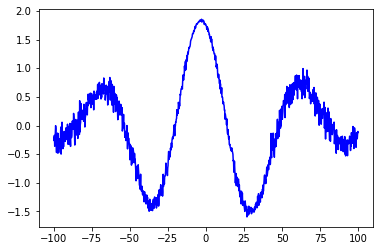

In [89]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "weibull") for x in tqdm(X)], 'b')
plt.show()

###### Exponential spectrum






  0%|          | 0/1000 [00:00<?, ?it/s]




  1%|          | 6/1000 [00:00<00:18, 53.53it/s]




  1%|          | 12/1000 [00:00<00:18, 53.56it/s]




  2%|▏         | 18/1000 [00:00<00:17, 54.81it/s]




  2%|▏         | 24/1000 [00:00<00:17, 54.79it/s]




  3%|▎         | 30/1000 [00:00<00:17, 55.63it/s]




  4%|▎         | 36/1000 [00:00<00:17, 55.22it/s]




  4%|▍         | 42/1000 [00:00<00:17, 54.78it/s]




  5%|▍         | 48/1000 [00:00<00:17, 55.53it/s]




  5%|▌         | 54/1000 [00:00<00:16, 56.14it/s]




  6%|▌         | 60/1000 [00:01<00:16, 55.60it/s]




  7%|▋         | 66/1000 [00:01<00:16, 56.03it/s]




  7%|▋         | 72/1000 [00:01<00:16, 56.06it/s]




  8%|▊         | 78/1000 [00:01<00:16, 56.42it/s]




  8%|▊         | 84/1000 [00:01<00:16, 56.82it/s]




  9%|▉         | 90/1000 [00:01<00:16, 56.06it/s]




 10%|▉         | 96/1000 [00:01<00:16, 56.31it/s]




 10%|█         | 102/1000 [00:01<00:16, 55.90it/s]




 11%|█         | 108/1000 [00:01

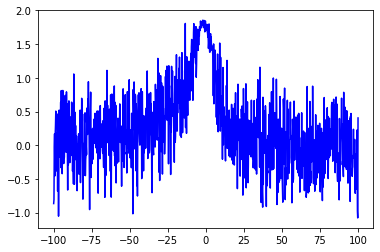

In [94]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "exponential") for x in tqdm(X)], 'b')
plt.show()






  0%|          | 0/1000 [00:00<?, ?it/s]




  0%|          | 1/1000 [00:00<03:08,  5.31it/s]




  0%|          | 2/1000 [00:00<03:14,  5.13it/s]




  0%|          | 3/1000 [00:00<03:05,  5.38it/s]




  0%|          | 4/1000 [00:00<03:00,  5.51it/s]




  0%|          | 5/1000 [00:00<02:58,  5.57it/s]




  1%|          | 6/1000 [00:01<02:56,  5.63it/s]




  1%|          | 7/1000 [00:01<02:56,  5.62it/s]




  1%|          | 8/1000 [00:01<02:56,  5.62it/s]




  1%|          | 9/1000 [00:01<02:56,  5.63it/s]




  1%|          | 10/1000 [00:01<02:55,  5.65it/s]




  1%|          | 11/1000 [00:01<02:54,  5.66it/s]




  1%|          | 12/1000 [00:02<02:54,  5.67it/s]




  1%|▏         | 13/1000 [00:02<02:54,  5.65it/s]




  1%|▏         | 14/1000 [00:02<02:55,  5.61it/s]




  2%|▏         | 15/1000 [00:02<02:56,  5.58it/s]




  2%|▏         | 16/1000 [00:02<02:57,  5.54it/s]




  2%|▏         | 17/1000 [00:03<03:01,  5.40it/s]




  2%|▏         | 18/1000 [00:03<03:01,  5

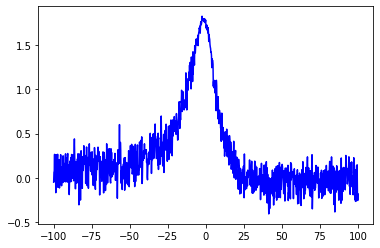

In [95]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "exponential") for x in tqdm(X)], 'b')
plt.show()

###### Logistic spectrum






  0%|          | 0/1000 [00:00<?, ?it/s]




  1%|          | 6/1000 [00:00<00:18, 54.76it/s]




  1%|          | 12/1000 [00:00<00:18, 54.67it/s]




  2%|▏         | 18/1000 [00:00<00:17, 54.78it/s]




  2%|▏         | 24/1000 [00:00<00:17, 54.50it/s]




  3%|▎         | 30/1000 [00:00<00:17, 55.06it/s]




  4%|▎         | 36/1000 [00:00<00:17, 55.88it/s]




  4%|▍         | 42/1000 [00:00<00:17, 53.59it/s]




  5%|▍         | 48/1000 [00:00<00:18, 50.74it/s]




  5%|▌         | 54/1000 [00:01<00:18, 50.95it/s]




  6%|▌         | 60/1000 [00:01<00:18, 52.06it/s]




  7%|▋         | 66/1000 [00:01<00:17, 53.06it/s]




  7%|▋         | 72/1000 [00:01<00:17, 54.04it/s]




  8%|▊         | 78/1000 [00:01<00:16, 54.32it/s]




  8%|▊         | 84/1000 [00:01<00:17, 53.80it/s]




  9%|▉         | 90/1000 [00:01<00:16, 54.24it/s]




 10%|▉         | 96/1000 [00:01<00:16, 54.89it/s]




 10%|█         | 102/1000 [00:01<00:15, 56.18it/s]




 11%|█         | 108/1000 [00:01

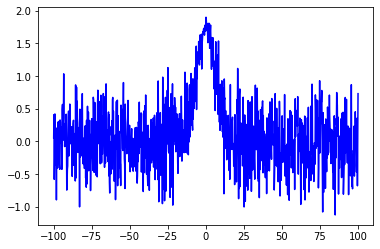

In [96]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "logistic") for x in tqdm(X)], 'b')
plt.show()






  0%|          | 0/1000 [00:00<?, ?it/s]




  0%|          | 1/1000 [00:00<02:48,  5.94it/s]




  0%|          | 2/1000 [00:00<02:47,  5.96it/s]




  0%|          | 3/1000 [00:00<02:47,  5.95it/s]




  0%|          | 4/1000 [00:00<02:48,  5.92it/s]




  0%|          | 5/1000 [00:00<02:51,  5.79it/s]




  1%|          | 6/1000 [00:01<02:51,  5.79it/s]




  1%|          | 7/1000 [00:01<02:50,  5.82it/s]




  1%|          | 8/1000 [00:01<02:51,  5.78it/s]




  1%|          | 9/1000 [00:01<02:52,  5.74it/s]




  1%|          | 10/1000 [00:01<02:50,  5.79it/s]




  1%|          | 11/1000 [00:01<02:52,  5.74it/s]




  1%|          | 12/1000 [00:02<02:53,  5.70it/s]




  1%|▏         | 13/1000 [00:02<03:01,  5.43it/s]




  1%|▏         | 14/1000 [00:02<03:09,  5.22it/s]




  2%|▏         | 15/1000 [00:02<03:11,  5.15it/s]




  2%|▏         | 16/1000 [00:02<03:06,  5.28it/s]




  2%|▏         | 17/1000 [00:03<03:02,  5.37it/s]




  2%|▏         | 18/1000 [00:03<03:00,  5

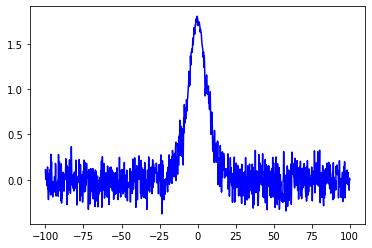

In [97]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "logistic") for x in tqdm(X)], 'b')
plt.show()

###### Lognormal spectrum






  0%|          | 0/1000 [00:00<?, ?it/s]




  1%|          | 6/1000 [00:00<00:17, 55.62it/s]




  1%|          | 12/1000 [00:00<00:17, 55.24it/s]




  2%|▏         | 18/1000 [00:00<00:17, 56.08it/s]




  2%|▏         | 24/1000 [00:00<00:17, 56.93it/s]




  3%|▎         | 30/1000 [00:00<00:17, 56.72it/s]




  4%|▎         | 36/1000 [00:00<00:17, 56.40it/s]




  4%|▍         | 42/1000 [00:00<00:17, 56.08it/s]




  5%|▍         | 48/1000 [00:00<00:17, 55.84it/s]




  5%|▌         | 54/1000 [00:00<00:16, 55.65it/s]




  6%|▌         | 60/1000 [00:01<00:16, 55.93it/s]




  7%|▋         | 66/1000 [00:01<00:16, 56.27it/s]




  7%|▋         | 72/1000 [00:01<00:17, 53.23it/s]




  8%|▊         | 78/1000 [00:01<00:16, 54.54it/s]




  8%|▊         | 84/1000 [00:01<00:16, 55.89it/s]




  9%|▉         | 90/1000 [00:01<00:16, 56.80it/s]




 10%|▉         | 96/1000 [00:01<00:16, 56.39it/s]




 10%|█         | 102/1000 [00:01<00:15, 56.48it/s]




 11%|█         | 108/1000 [00:01

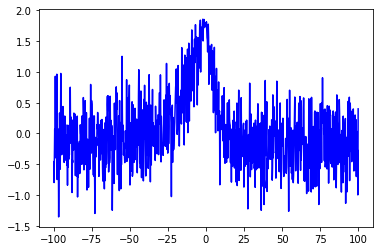

In [98]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "lognormal") for x in tqdm(X)], 'b')
plt.show()






  0%|          | 0/1000 [00:00<?, ?it/s]




  0%|          | 1/1000 [00:00<02:53,  5.75it/s]




  0%|          | 2/1000 [00:00<02:51,  5.81it/s]




  0%|          | 3/1000 [00:00<02:50,  5.84it/s]




  0%|          | 4/1000 [00:00<02:51,  5.80it/s]




  0%|          | 5/1000 [00:00<02:51,  5.82it/s]




  1%|          | 6/1000 [00:01<02:50,  5.82it/s]




  1%|          | 7/1000 [00:01<02:51,  5.81it/s]




  1%|          | 8/1000 [00:01<02:50,  5.82it/s]




  1%|          | 9/1000 [00:01<02:50,  5.82it/s]




  1%|          | 10/1000 [00:01<02:49,  5.84it/s]




  1%|          | 11/1000 [00:01<02:49,  5.85it/s]




  1%|          | 12/1000 [00:02<02:48,  5.87it/s]




  1%|▏         | 13/1000 [00:02<02:48,  5.86it/s]




  1%|▏         | 14/1000 [00:02<02:47,  5.88it/s]




  2%|▏         | 15/1000 [00:02<02:48,  5.86it/s]




  2%|▏         | 16/1000 [00:02<02:48,  5.83it/s]




  2%|▏         | 17/1000 [00:02<02:48,  5.82it/s]




  2%|▏         | 18/1000 [00:03<02:48,  5

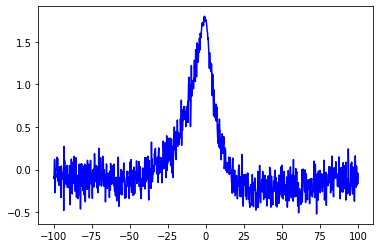

In [100]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "lognormal") for x in tqdm(X)], 'b')
plt.show()

###### Pareto spectrum

100%|██████████| 1000/1000 [00:17<00:00, 58.29it/s]


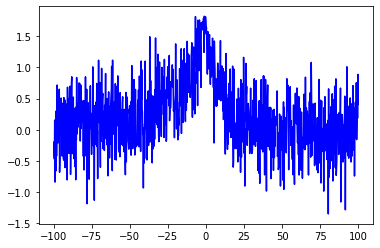

In [102]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 10, "pareto") for x in tqdm(X)], 'b')
plt.show()

100%|██████████| 1000/1000 [02:49<00:00,  5.89it/s]


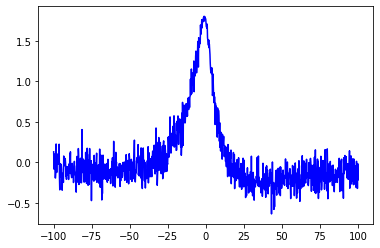

In [103]:
X = np.linspace(-100, 100, num = 1000)
plt.plot(X, [kernel(np.array([x, 0]), np.array([0, 0]), 100, "lognormal") for x in tqdm(X)], 'b')
plt.show()

### Score

The score uses the usual formula. However, it is computed by using a yet unused set (what one may call a test set).

In [15]:
def q_score(X, y, c_opt_val): # quantum score
    """
    Computes the score over the given set X and labels y using the given c_opt vector.
    """
    cpt = 0
    print(">>> Scoring")
    for i in tqdm(range(len(X))):
        if np.sign(q_classifier(c_opt_val, X[i])) == y[i]: cpt += 1
    return cpt / len(X)

### Graphical representation

The plot shows another unused set with the classification of the square $[-1.1, 1.1] \times [-1.1, 1.1]$.

In [16]:
def plot_q_classification(X, y, c_opt_val, ret):
    """
    Defines the graphical representation which contains some points and their corresponding labels,
    the background is the classification of the square [-1.1, 1.1] x [-1.1, 1.1] and the score (given
    in the input) written in the title.
    """
    plt.figure(figsize=(8,8))# Generate figure

    # create a mesh for the background
    xx = np.arange(-1.1, 1.1, h)
    yy = np.arange(-1.1, 1.1, h)
    zs = np.zeros((len(xx), len(yy)))
    print(">>> Plotting")
    for i in tqdm(range(len(xx))):
        for j in range(len(yy)):
            zs[i, j] = np.sign(q_classifier(c_opt_val, np.array([xx[i], yy[j]])))
    cs = plt.contourf(xx, yy, zs, cmap=plt.cm.coolwarm)
    plt.colorbar(cs)

    # Plot scatter points
    plt.scatter(
        X[y == -1, 1],
        X[y == -1, 0],
        s=4,
        label='-1',
        alpha=1, c = ["#0cf9f1"]
    )
    plt.scatter(
        X[y == 1, 1],
        X[y == 1, 0],
        s=4,
        label='1',
        alpha=1,
        c = ["#790909"]
    )

    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    lgnd = plt.legend(fontsize=5)

    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    for it in range(2):
        lgnd.legendHandles[it]._sizes = [40]
    plt.title("score = " + str(ret))  # write the score in the title
    plt.show()

### Wrapper

This wrapper calls the functions defined before. It starts by defining the Fourier spectrum (using eventually the user input), then redefines $R$, which turned out to be a *very important* parameter in the classification. This redefinition is done accordingly to the type of datast. Afterwards, it generates the data set (using the noise parameter if it is given) and divides it into three subsets (training, test and grapical representation). Then, it computes the vector $z(X)$ and solves the linear system. Finally, it computes the score and shows the graphical representation.

In [17]:
def q_fit(type, N=1000, noise_param=None, name_law=None):
    """
    Wrapper that uses a prepared quantum kernel in order to call all the classification steps:
    1. Fourier spectrum definition, R redefinition and data generation using noise_param if not noise_param is None
    2. Definition of c_opt by resolving the linear system
    3. Score computation
    4. Graphical representation
    
    >> Default noise values:
        - linear dataset: 2
        - circular dataset: 0.03
        - lunar dataset: 0.1
        
    >> Available names (by default normal):
    
        - exponential: np.random.exponential(size = d)
        - chisquare: np.random.chisquare(1, size = d)
        - beta: np.random.beta(2, 2, size = d)
        - lognormal: np.random.lognormal(size = d)
        - logistic: np.random.logistic(size = d)
        - laplace: np.random.laplace(size = d)
        - gamma: np.random.gamma(2, size = d)
        - triangular: np.random.triangular(-1, 1, size = d)
        - cauchy: np.random.standard_cauchy(size = d)
        - pareto: np.random.pareto(1, size = d)
        - normal: np.random.normal(size = d)
        - vonmises: np.random.vonmises(0, 4, size = d)
        - uniform: np.random.uniform(low=-1, high=1, size = d)
        - wald: np.random.wald(3, 2, size = d)
        - weibull: np.random.weibull(5, size = d)
        - student: np.random.standard_t(1, size = d)
        - f (Fisher-Snedecor): np.random.f(100, 100, size = d)
    """
    global R, w, b, gamma # redefine R according to the type of dataset
    gamma = .1
    if type == 0: R = 3
    elif type == 1: R = 10
    elif type == 2: R = 20
    # defintion of the random Fourier feature
    w = []
    b = []
    if name_law is None:
        for i in range(R):
            temp1, temp2 = random_parameter("normal")
            w.append(temp1)
            b.append(temp2)
    else:
        for i in range(R):
            temp1, temp2 = random_parameter(name_law)
            w.append(temp1)
            b.append(temp2)
        
    X, y = generate_data(type, N, noise_param)  # data generation - noise redefinition
    # divide dataset into train, test, graphical
    prop1 = int(0.8 * len(y))
    prop2 = int(0.9 * len(y))
    c_opt_val = c_opt(qZ(X[:prop1]), y[:prop1]) # train in order to learn c_opt
    ret = q_score(X[prop1:prop2], y[prop1:prop2], c_opt_val) # score computation
    print("\n>>>>>> quantum score = ", ret)
    plot_q_classification(X[prop2:], y[prop2:], c_opt_val, ret) # graphical representation
    return ret

### Examples

The RKS algorithm seems to give excellent results on different datasets, even complex ones. Moreover, thanks to the reduction of the dimension of the dimension, the algorithm is fast.

It is easy to observe that the different kernels provide relatively the same resuly quality. As a matter of fact, the different "kernels" look like roughly the same in the range $[-2, 2]$. Our normalization was thus useful since it avoided the problematic range of values that exist in some "kernels".

>>> Resolve linear system


100%|██████████| 800/800 [00:02<00:00, 366.50it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 377.29it/s]



>>>>>> quantum score =  1.0
>>> Plotting


100%|██████████| 74/74 [00:14<00:00,  5.20it/s]


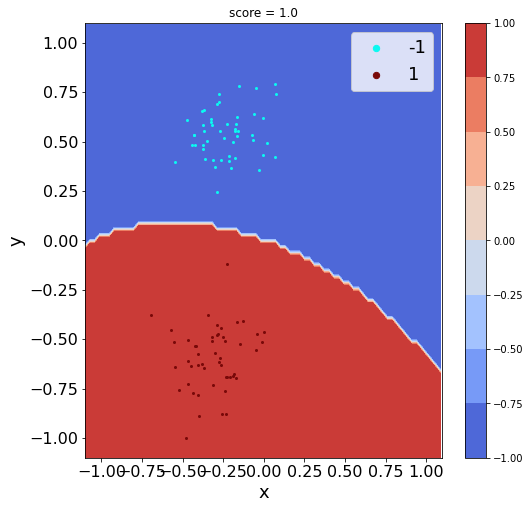

1.0

In [20]:
q_fit(0, 1000, name_law="chisquare")

>>> Resolve linear system


100%|██████████| 800/800 [00:02<00:00, 366.67it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 383.56it/s]



>>>>>> quantum score =  0.96
>>> Plotting


100%|██████████| 74/74 [00:13<00:00,  5.32it/s]


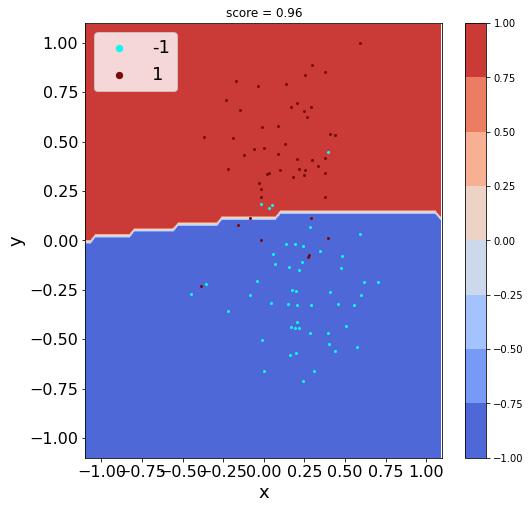

0.96

In [38]:
q_fit(0, 1000, name_law="uniform")

>>> Resolve linear system


100%|██████████| 800/800 [00:02<00:00, 381.48it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 384.98it/s]



>>>>>> quantum score =  0.76
>>> Plotting


100%|██████████| 74/74 [00:14<00:00,  5.26it/s]


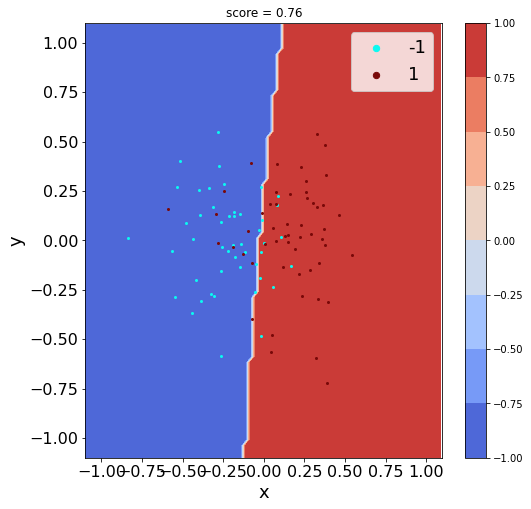

0.76

In [29]:
q_fit(0, 1000, name_law="normal")

>>> Resolve linear system


100%|██████████| 800/800 [00:02<00:00, 375.82it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 376.62it/s]



>>>>>> quantum score =  1.0
>>> Plotting


100%|██████████| 74/74 [00:14<00:00,  5.26it/s]


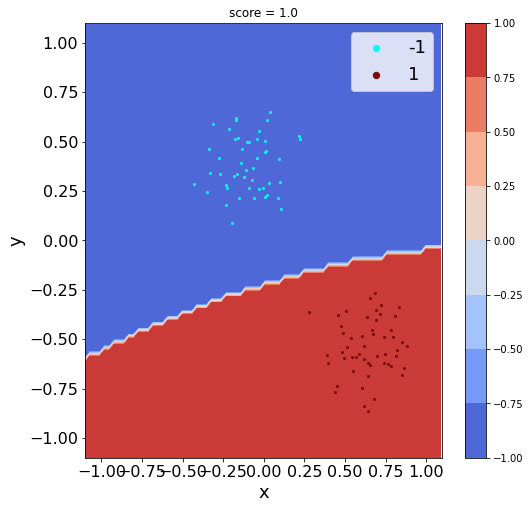

1.0

In [32]:
q_fit(0, 1000, name_law="student")

>>> Resolve linear system


100%|██████████| 800/800 [00:02<00:00, 368.82it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 378.74it/s]



>>>>>> quantum score =  1.0
>>> Plotting


100%|██████████| 74/74 [00:14<00:00,  5.10it/s]


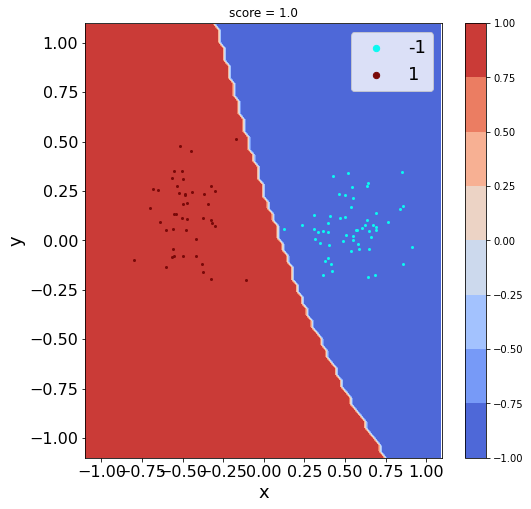

1.0

In [21]:
q_fit(0, 1000, name_law="pareto")

>>> Resolve linear system


100%|██████████| 800/800 [00:02<00:00, 378.31it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 337.78it/s]



>>>>>> quantum score =  0.92
>>> Plotting


100%|██████████| 74/74 [00:13<00:00,  5.31it/s]


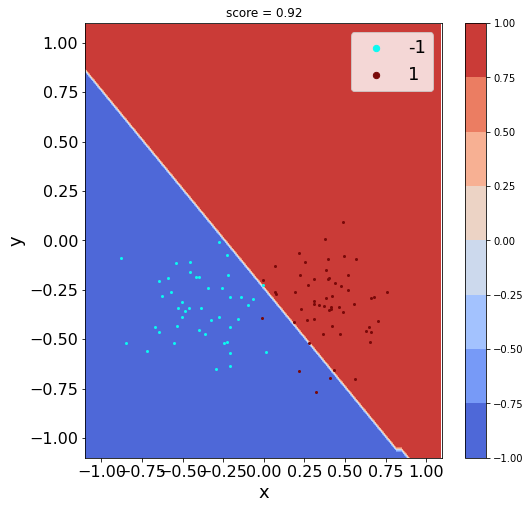

0.92

In [43]:
q_fit(0, 1000, name_law="f")

>>> Resolve linear system


100%|██████████| 800/800 [00:02<00:00, 376.39it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 363.54it/s]



>>>>>> quantum score =  0.93
>>> Plotting


100%|██████████| 74/74 [00:14<00:00,  5.19it/s]


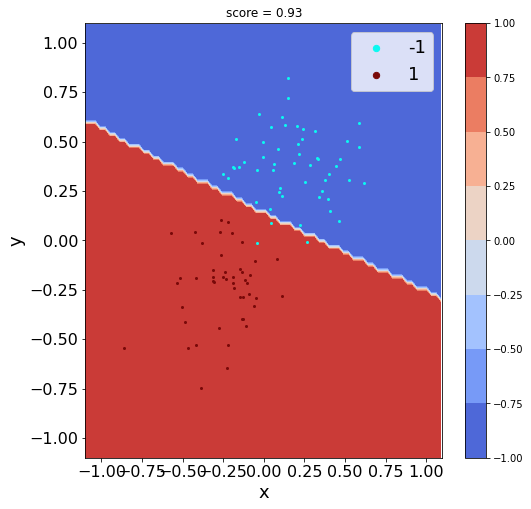

0.93

In [24]:
q_fit(0, 1000, noise_param=5, name_law="gamma")

>>> Resolve linear system


100%|██████████| 800/800 [00:07<00:00, 113.41it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 115.06it/s]



>>>>>> quantum score =  1.0
>>> Plotting


100%|██████████| 74/74 [00:45<00:00,  1.62it/s]


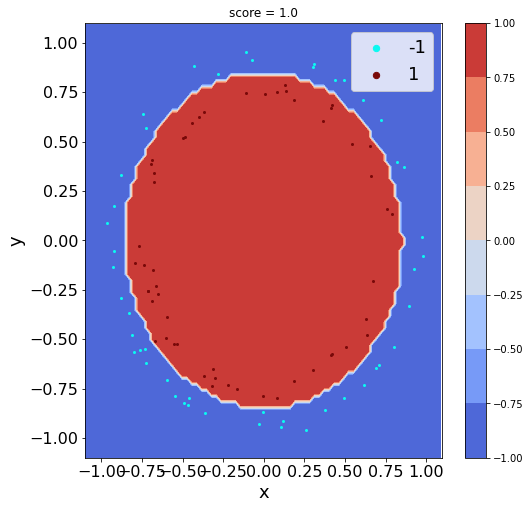

1.0

In [25]:
q_fit(1, 1000, name_law="vonmises")

>>> Resolve linear system


100%|██████████| 800/800 [00:06<00:00, 123.27it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 125.29it/s]



>>>>>> quantum score =  0.99
>>> Plotting


100%|██████████| 74/74 [00:42<00:00,  1.74it/s]


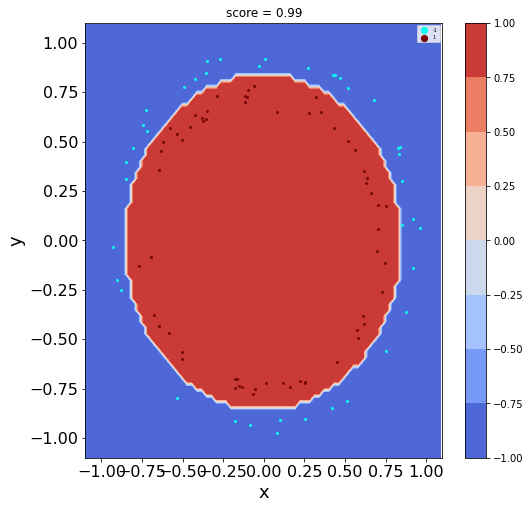

0.99

In [18]:
q_fit(1, 1000, name_law="weibull")

>>> Resolve linear system







  0%|          | 0/800 [00:00<?, ?it/s]




  1%|▏         | 11/800 [00:00<00:07, 109.53it/s]




  3%|▎         | 22/800 [00:00<00:07, 107.34it/s]




  4%|▍         | 34/800 [00:00<00:07, 109.05it/s]




  6%|▌         | 45/800 [00:00<00:06, 108.22it/s]




  7%|▋         | 56/800 [00:00<00:06, 108.79it/s]




  8%|▊         | 67/800 [00:00<00:06, 108.97it/s]




 10%|▉         | 79/800 [00:00<00:06, 110.35it/s]




 11%|█▏        | 91/800 [00:00<00:06, 109.87it/s]




 13%|█▎        | 102/800 [00:00<00:06, 108.85it/s]




 14%|█▍        | 114/800 [00:01<00:06, 109.54it/s]




 16%|█▌        | 125/800 [00:01<00:06, 108.80it/s]




 17%|█▋        | 137/800 [00:01<00:06, 110.03it/s]




 19%|█▊        | 149/800 [00:01<00:05, 110.47it/s]




 20%|██        | 161/800 [00:01<00:05, 111.50it/s]




 22%|██▏       | 173/800 [00:01<00:05, 112.71it/s]




 23%|██▎       | 185/800 [00:01<00:05, 112.67it/s]




 25%|██▍       | 197/800 [00:01<00:05, 104.87it/s]




 26%|██▌       | 208/800

>>> Scoring







  0%|          | 0/100 [00:00<?, ?it/s]




 12%|█▏        | 12/100 [00:00<00:00, 111.82it/s]




 24%|██▍       | 24/100 [00:00<00:00, 111.95it/s]




 36%|███▌      | 36/100 [00:00<00:00, 110.75it/s]




 48%|████▊     | 48/100 [00:00<00:00, 109.35it/s]




 60%|██████    | 60/100 [00:00<00:00, 110.85it/s]




 72%|███████▏  | 72/100 [00:00<00:00, 112.08it/s]




 84%|████████▍ | 84/100 [00:00<00:00, 112.71it/s]




100%|██████████| 100/100 [00:00<00:00, 111.63it/s][A



>>>>>> quantum score =  1.0
>>> Plotting







  0%|          | 0/74 [00:00<?, ?it/s]




  1%|▏         | 1/74 [00:00<00:44,  1.63it/s]




  3%|▎         | 2/74 [00:01<00:43,  1.64it/s]




  4%|▍         | 3/74 [00:01<00:43,  1.63it/s]




  5%|▌         | 4/74 [00:02<00:42,  1.64it/s]




  7%|▋         | 5/74 [00:03<00:42,  1.64it/s]




  8%|▊         | 6/74 [00:03<00:41,  1.64it/s]




  9%|▉         | 7/74 [00:04<00:40,  1.64it/s]




 11%|█         | 8/74 [00:04<00:40,  1.64it/s]




 12%|█▏        | 9/74 [00:05<00:39,  1.63it/s]




 14%|█▎        | 10/74 [00:06<00:39,  1.63it/s]




 15%|█▍        | 11/74 [00:06<00:38,  1.64it/s]




 16%|█▌        | 12/74 [00:07<00:38,  1.63it/s]




 18%|█▊        | 13/74 [00:07<00:37,  1.63it/s]




 19%|█▉        | 14/74 [00:08<00:36,  1.63it/s]




 20%|██        | 15/74 [00:09<00:36,  1.64it/s]




 22%|██▏       | 16/74 [00:09<00:35,  1.63it/s]




 23%|██▎       | 17/74 [00:10<00:34,  1.63it/s]




 24%|██▍       | 18/74 [00:11<00:34,  1.63it/s]




 26%|██▌       | 19/74 [0

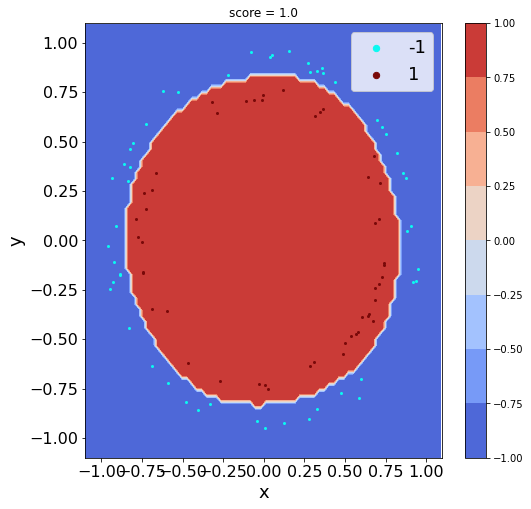

1.0

In [101]:
q_fit(1, 1000, name_law="lognormal")

>>> Resolve linear system


100%|██████████| 800/800 [00:07<00:00, 111.52it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 116.09it/s]



>>>>>> quantum score =  0.71
>>> Plotting


100%|██████████| 74/74 [00:46<00:00,  1.58it/s]


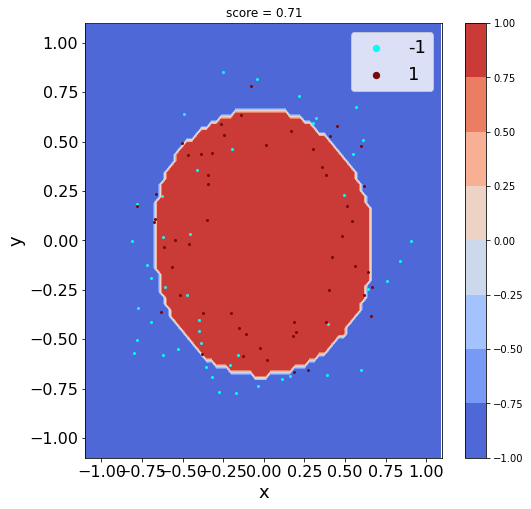

0.71

In [26]:
q_fit(1, 1000, noise_param=0.15, name_law="wald")

>>> Resolve linear system


100%|██████████| 800/800 [00:07<00:00, 111.41it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 114.60it/s]



>>>>>> quantum score =  0.76
>>> Plotting


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


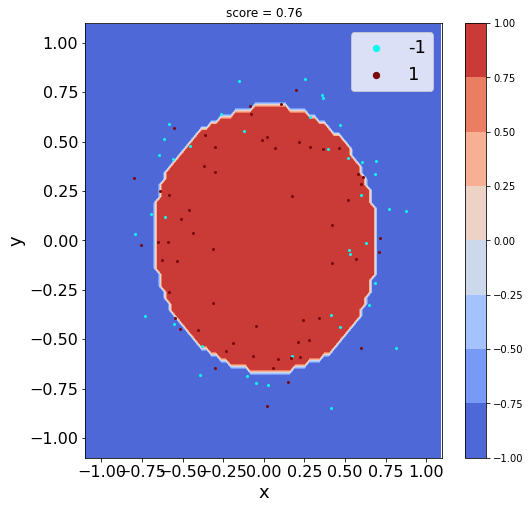

0.76

In [33]:
q_fit(1, 1000, noise_param=0.15, name_law="beta")

>>> Resolve linear system


100%|██████████| 800000/800000 [3:49:56<00:00, 57.99it/s]  


>>> Scoring


100%|██████████| 100000/100000 [28:24<00:00, 58.67it/s]



>>>>>> quantum score =  0.99731
>>> Plotting


100%|██████████| 74/74 [01:28<00:00,  1.20s/it]


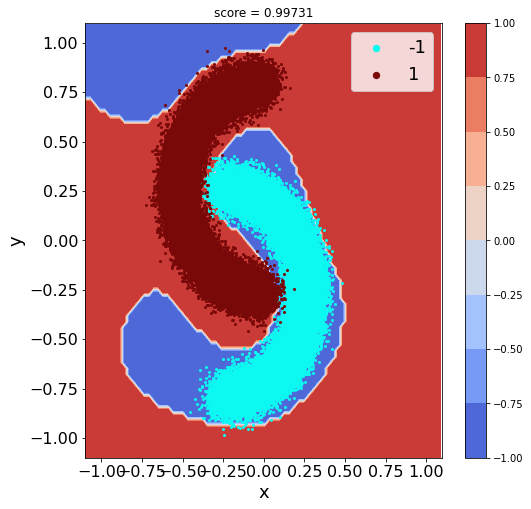

0.99731

In [105]:
q_fit(2, 1000000, name_law="laplace")

>>> Resolve linear system


100%|██████████| 8000/8000 [02:16<00:00, 58.57it/s]


>>> Scoring


100%|██████████| 1000/1000 [00:16<00:00, 59.84it/s]



>>>>>> quantum score =  0.802
>>> Plotting


100%|██████████| 74/74 [01:28<00:00,  1.19s/it]


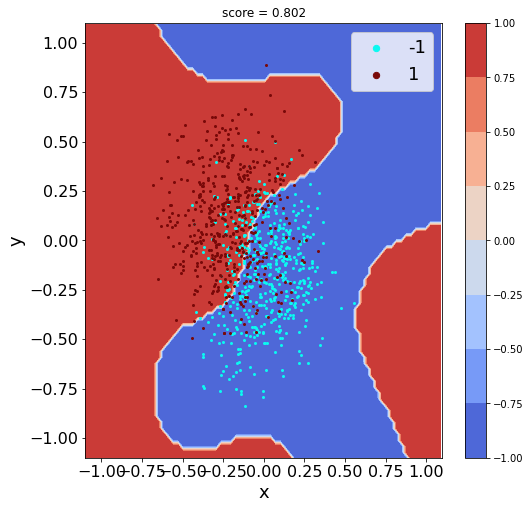

0.802

In [106]:
q_fit(2, 10000, noise_param=.6, name_law="logistic")

>>> Resolve linear system


100%|██████████| 800/800 [00:14<00:00, 56.91it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 58.43it/s]



>>>>>> quantum score =  0.75
>>> Plotting


100%|██████████| 74/74 [01:31<00:00,  1.24s/it]


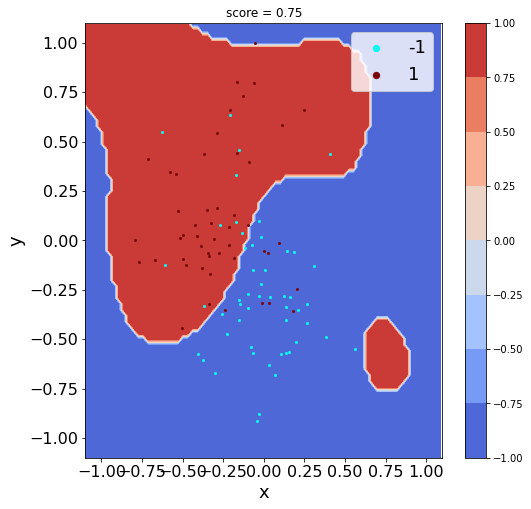

0.75

In [36]:
q_fit(2, 1000, noise_param=.6, name_law="cauchy")

>>> Resolve linear system


100%|██████████| 800/800 [00:12<00:00, 62.83it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 62.74it/s]



>>>>>> quantum score =  0.98
>>> Plotting


100%|██████████| 74/74 [01:24<00:00,  1.14s/it]


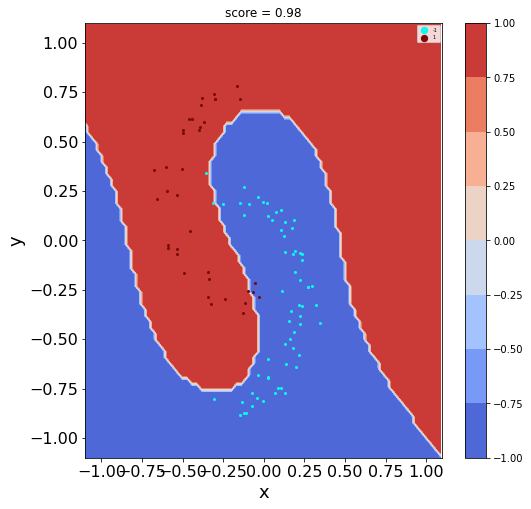

0.98

In [19]:
q_fit(2, 1000, name_law="f")

### Test with *ad hoc* Qiskit data

Here, we test the RKS method on the complex dataset *ad hoc* of Qiskit. This is a database generated through a quantum circuit as explained <a href="https://arxiv.org/pdf/1804.11326.pdf">here</a>.

In [194]:
def transform_label(labs):
    res = []
    for i in range(len(labs)):
        if labs[i, 0] == 1. and labs[i, 1] == 0.:
            res.append(1)
        elif labs[i, 0] == 0. and labs[i, 1] == 1.:
            res.append(-1)
        else:
            raise(ValueError(labs[i]))
    return np.reshape(np.array(res), (len(res),))

feature_dim = 2

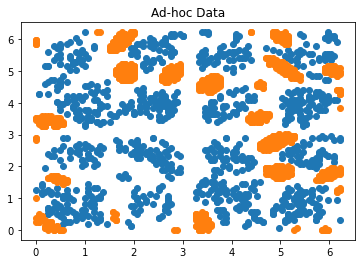

In [210]:
training_feature_array, training_label_array, test_feature_array, test_label_array, sample_total = ad_hoc_data(
    training_size=1000,
    test_size=100,
    n=feature_dim,
    gap=0.3,
    plot_data=True,
    include_sample_total=True
)

# transforming the labels into -1/1 labels
training_label_array=transform_label(training_label_array)
test_label_array=transform_label(test_label_array)
# normalizing the data points
training_feature_array = normalizeX(training_feature_array)
test_feature_array = normalizeX(test_feature_array)

#### Test with a classical algorithm: Random Forest

We start by testing our algorithm on a well-known classical algorithm: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">random forest</a>. Not only does it serve for comparaison purposes with our quantum classifier, but also it helps us to understand the database itself.

In [211]:
clf = RandomForestClassifier()
clf.fit(training_feature_array, training_label_array)

RandomForestClassifier()

In [219]:
def plot_classical_classification(X, y, clf):
    # Generate figure
    plt.figure(figsize=(8,8))

    # create a mesh for the background

    xx = np.arange(-1.1, 1.1, h)
    yy = np.arange(-1.1, 1.1, h)
    zs = np.zeros((len(xx), len(yy)))
    for i in tqdm(range(len(xx))):
        for j in range(len(yy)):
            zs[i, j] = clf.predict([[xx[i], yy[j]]])[0]
    cs = plt.contourf(xx, yy, zs, cmap=plt.cm.coolwarm)
    plt.colorbar(cs)

    # Plot scatter points
    plt.scatter(
        X[y == -1, 1],
        X[y == -1, 0],
        s=4,
        label='-1',
        alpha=1, c = ["#0cf9f1"]
    )
    plt.scatter(
        X[y == 1, 1],
        X[y == 1, 0],
        s=4,
        label='1',
        alpha=1,
        c = ["#790909"]
    )

    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    lgnd = plt.legend(fontsize=5)

    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1,1.1)
    for it in range(2):
        lgnd.legendHandles[it]._sizes = [40]
    plt.title("score = " + str(clf.score(X, y)))  # write the score in the title
    plt.show()

100%|██████████| 74/74 [00:53<00:00,  1.37it/s]


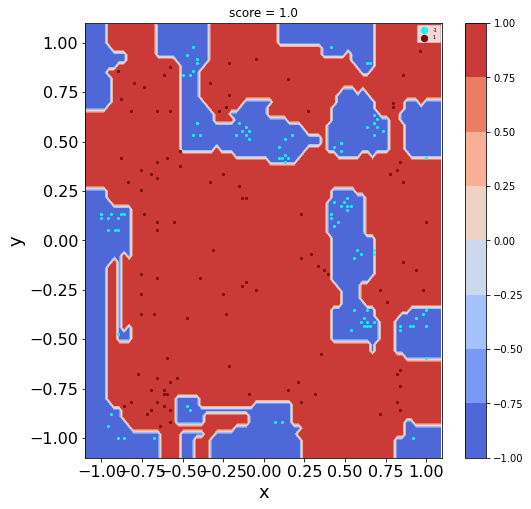

In [220]:
plot_classical_classification(test_feature_array, test_label_array, clf)

#### Use of the RKS algorithm

The *ad hoc* database is hard because its spacial features are not the relevant features. As a matter of fact, <a href="https://arxiv.org/pdf/1804.11326.pdf">this article</a> explains that one needs to work on a high-dimensional vector space in order to retrieve the describing features. 

The RKS algorithm does not learn the aforementioned features. Instead, its high expressivity allows it to define complex classification zones in the spatial feature space. Our hope is that such a complex classification can compensate the lack of information provided by the spatial features. The drawback is that we need relatively large values of $R$, which increases the runtime (which is $O(R^3)$ according to <a href="https://arxiv.org/abs/2107.05224v1">Gan et al</a>). One way to limit the increase of $R$ is to increase the value of $\gamma$. In fact, increasing the value of $\gamma$ improves the result since it increases the *perceived* distance between the points.

Through trial and error, we found that the following values produce good results:

\begin{align*}
R &= 75\\
\gamma &= 10
\end{align*}

By contrast to the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">random forest</a> algorithm, the classification obtained through RKS seems to be less "artificial". The RKS method seems to present less over-fitting than random forest. Moreover, the simulation of the photonic circuit is optimized in Perceval, which saves runtime.

In [213]:
R = 75
gamma = 10
w = []
b = []
for i in range(R):
    temp1, temp2 = random_parameter("normal")
    w.append(temp1)
    b.append(temp2)

>>> Resolve linear system


100%|██████████| 2000/2000 [02:11<00:00, 15.22it/s]


>>> Scoring


100%|██████████| 200/200 [00:12<00:00, 15.69it/s]



>>>>>> quantum score =  0.955
>>> Plotting


100%|██████████| 74/74 [05:36<00:00,  4.55s/it]


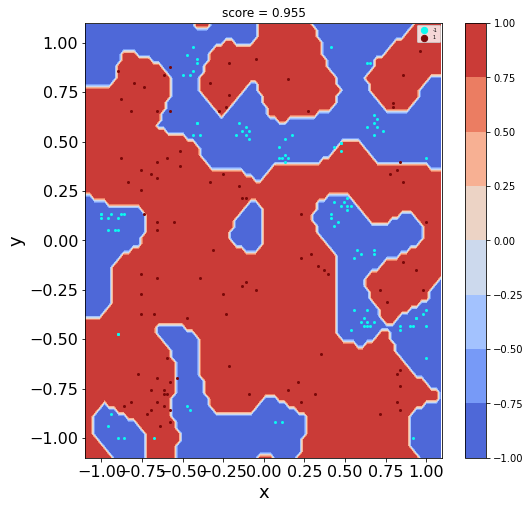

In [214]:
c_opt_val = c_opt(qZ(training_feature_array), training_label_array) # train in order to learn c_opt
ret = q_score(test_feature_array, test_label_array, c_opt_val) # score computation
print("\n>>>>>> quantum score = ", ret)
plot_q_classification(test_feature_array, test_label_array, c_opt_val, ret)

### Test with real data sets

Here, we test our method on some real databases. The first one concerns breast cancer.

#### Breast cancer data set

This breast cancer databases was obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg. The following sources are to be mentioned:

1. O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

2. William H. Wolberg and O.L. Mangasarian: "Multisurface method of pattern separation for medical diagnosis applied to breast cytology", Proceedings of the National Academy of Sciences, U.S.A., Volume 87, December 1990, pp 9193-9196.

3. O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition via linear programming: Theory and application to medical diagnosis", in: "Large-scale numerical optimization", Thomas F. Coleman and Yuying Li, editors, SIAM Publications, Philadelphia 1990, pp 22-30.

4. K. P. Bennett & O. L. Mangasarian: "Robust linear programming discrimination of two linearly inseparable sets", Optimization Methods and Software 1, 1992, 23-34 (Gordon & Breach Science Publishers).

In [253]:
def normalizeX_c(z):
    """
    Values between -1 and 1
    """
    for i in range(len(z[0])):
        zmax = np.max(z[:, i])
        zmin = np.min(z[:, i])
        z[:, i] = 2 * (z[:, i] - zmin) / (zmax - zmin) - 1
    return z / np.sqrt(len(z[0]))



def normalizey_c(z):
    """
    Values between -1 and 1
    """
    for i in range(len(z)):
        if z[i] == 2:
            z[i] = -1
        else:
            z[i] = 1
    return z

In [276]:
def q_score_(X, y, c_opt_val): # quantum score
    global TP, FN, FP, TN
    cpt = 0
    print(">>> Score computation")
    for i in tqdm(range(len(X))):
        predicted = np.sign(q_classifier(c_opt_val, X[i]))
        if predicted == 1:
            if y[i] == 1:
                TP += 1
                cpt += 1
            else:
                FP += 1
        elif predicted == -1:
            if y[i] == -1:
                TN += 1
                cpt += 1
            else:
                FN += 1
    return cpt / len(X)

def mcc(TP, FN, FP, TN):
    den = (TP + FP)*(TP + FN)*(TN + FP)*(TN + FN)
    if den == 0: return 1
    return (TP * TN - FP * FN) / np.sqrt(den)

In [284]:
X = normalizeX_c(np.genfromtxt("Database/breast-cancer-wisconsin.txt", skip_header=0, usecols=[i for i in range(1, 10)]))
y = normalizey_c(np.genfromtxt("Database/breast-cancer-wisconsin.txt", skip_header=0, usecols=[10]))
d = len(X[0])
prop = int(len(X) * .8)
X_train = X[:prop]
y_train = y[:prop]

X_test = X[prop:]
y_test = y[prop:]

In [271]:
R = 15
gamma = 1
w = []
b = []
for i in range(R):
    temp1, temp2 = random_parameter("student", d)
    w.append(temp1)
    b.append(temp2)

In [285]:
TP, FN, FP, TN = 0, 0, 0, 0
c_opt_val = c_opt(qZ(X_train), y_train) # train in order to learn c_opt
ret = q_score_(X_test, y_test, c_opt_val) # score computation
print(">>> Test results")
print("Total number: ", len(X_test))
print("Confusion Matrix:")
print("______________________")
print("| TP = ", TP, "| FN = ", FN, "|")
print("---------------------")
print("| FP = ", FP, "| TN = ", TN, "|")
print("______________________")
print("MCC: ", mcc(TP, FN, FP, TN))
print("\n>>>>>> quantum score = ", ret)

>>> Resolve linear system


100%|██████████| 546/546 [00:07<00:00, 76.48it/s]


>>> Score computation


100%|██████████| 137/137 [00:01<00:00, 79.23it/s]

>>> Test results
Total number:  137
Confusion Matrix:
______________________
| TP =  31 | FN =  4 |
---------------------
| FP =  1 | TN =  101 |
______________________
MCC:  0.9028677374864443

>>>>>> quantum score =  0.9635036496350365


#### Thales Side Channel attack

This database contains some features (Fourier transforms, CWT transforms, mean...) of the time series of energy consumption of some device encoding a *secret key*. Such information can be used by some hacker in order to deduce the key. For the sake of simplicity, we only try to deduce a binary classification. We use data sets provided by Thales from <a href="https://github.com/ANSSI-FR/ASCAD">ASCAD</a>.

In [286]:
def normalizeX_t(z):
    """
    Values between -1 and 1
    """
    for i in range(len(z[0])):
        zmax = np.max(z[:, i])
        zmin = np.min(z[:, i])
        z[:, i] = 2 * (z[:, i] - zmin) / (zmax - zmin) - 1
    return z / np.sqrt(len(z[0]))



def normalizey_t(z):
    """
    Values between -1 and 1
    """
    for i in range(len(z)):
        if z[i] == 0:
            z[i] = -1
    return z

In [287]:
# train data
X_train = normalizeX_t(np.genfromtxt("Database/X_train.txt", skip_header=1, usecols=[i for i in range(15)]))
y_train = normalizey_t(np.genfromtxt("Database/ytrain_labels.txt", skip_header=0))
d = len(X_train[0])  # the dimension of the data points

# test data
X_test = normalizeX_t(np.genfromtxt("Database/X_test.txt", skip_header=1, usecols=[i for i in range(15)]))
y_test = normalizey_t(np.genfromtxt("Database/ytest_label.txt", skip_header=0))

In [290]:
R = 10
gamma = 1
w = []
b = []
for i in range(R):
    temp1, temp2 = random_parameter("f", d)
    w.append(temp1)
    b.append(temp2)

In [291]:
TP, FN, FP, TN = 0, 0, 0, 0
c_opt_val = c_opt(qZ(X_train), y_train) # train in order to learn c_opt
ret = q_score_(X_test, y_test, c_opt_val) # score computation
print(">>> Test results")
print("Total number: ", len(X_test))
print("Confusion Matrix:")
print("______________________")
print("| TP = ", TP, "| FN = ", FN, "|")
print("---------------------")
print("| FP = ", FP, "| TN = ", TN, "|")
print("______________________")
print("MCC: ", mcc(TP, FN, FP, TN))
print("\n>>>>>> quantum score = ", ret)

>>> Resolve linear system


100%|██████████| 402/402 [00:03<00:00, 117.31it/s]


>>> Score computation


100%|██████████| 66/66 [00:00<00:00, 116.76it/s]

>>> Test results
Total number:  66
Confusion Matrix:
______________________
| TP =  28 | FN =  2 |
---------------------
| FP =  1 | TN =  35 |
______________________
MCC:  0.9085045695904671

>>>>>> quantum score =  0.9545454545454546
